In [1]:
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, r2_score 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

In [3]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
f = pd.read_csv('df_data.csv')
df = pd.DataFrame(f)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 27 columns):
euribor3m            41176 non-null float64
cons.conf.idx        41176 non-null float64
age                  41176 non-null float64
previous             41176 non-null float64
blue_collar          41176 non-null int64
student              41176 non-null int64
retiree              41176 non-null int64
unemployed           41176 non-null int64
single               41176 non-null int64
no_default           41176 non-null int64
age_student          41176 non-null float64
age_retiree          41176 non-null float64
contact_telephone    41176 non-null int64
month_aug            41176 non-null int64
month_dec            41176 non-null int64
month_jul            41176 non-null int64
month_jun            41176 non-null int64
month_mar            41176 non-null int64
month_may            41176 non-null int64
month_nov            41176 non-null int64
month_oct            41176 non-null int

In [6]:
# Baseline forecast of 11.3% on the positive class.
df.target.value_counts(normalize=True)

0    0.887337
1    0.112663
Name: target, dtype: float64

# Scaling Explanatory Variables & Choosing Scoring Metric

In [7]:
y = df.pop('target')

In [8]:
X = df

In [9]:
X.columns

Index(['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar',
       'student', 'retiree', 'unemployed', 'single', 'no_default',
       'age_student', 'age_retiree', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=8)

In [11]:
X_train.describe()

,euribor3m,cons.conf.idx,age,previous,blue_collar,student,retiree,unemployed,single,no_default,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
count,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,...,28823.000000,28823.000000,28823.00000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000
mean,3.623106,-40.520404,39.984041,0.172779,0.222912,0.020747,0.040731,0.024217,0.281546,0.792561,...,0.129515,0.012906,0.33279,0.099886,0.017521,0.013600,0.207265,0.209728,0.196718,0.197516
std,1.733399,4.618578,10.399902,0.495331,0.416207,0.142540,0.197671,0.153724,0.449761,0.405479,...,0.335774,0.112873,0.47122,0.299852,0.131203,0.115826,0.405354,0.407122,0.397524,0.398132
min,0.634000,-50.800000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.344000,-42.700000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.857000,-41.800000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.961000,-36.400000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.045000,-26.900000,98.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Will use MinMax scaler to scale the variables because (1) I don't need a normally distributed data because not using OLS, (2) plus this is a sizeable dataset, and (2) the prevalence of dummy variables in the dataset.

In [12]:
scaler = MinMaxScaler()
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.transform(X_test)

In [13]:
X_train = pd.DataFrame(X_train_mm, columns=['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar',
       'student', 'retiree', 'unemployed', 'single', 'no_default', 'age_student', 'age_retiree', 'contact_telephone', 
        'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
        'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed'])

In [14]:
X_test = pd.DataFrame(X_test_mm, columns=['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar',
       'student', 'retiree', 'unemployed', 'single', 'no_default', 'age_student', 'age_retiree', 'contact_telephone', 
        'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
        'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed'])

In [15]:
X_train.describe()

,euribor3m,cons.conf.idx,age,previous,blue_collar,student,retiree,unemployed,single,no_default,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
count,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,...,28823.000000,28823.000000,28823.00000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000
mean,0.677648,0.430109,0.283754,0.028796,0.222912,0.020747,0.040731,0.024217,0.281546,0.792561,...,0.129515,0.012906,0.33279,0.099886,0.017521,0.013600,0.207265,0.209728,0.196718,0.197516
std,0.392972,0.193246,0.128394,0.082555,0.416207,0.142540,0.197671,0.153724,0.449761,0.405479,...,0.335774,0.112873,0.47122,0.299852,0.131203,0.115826,0.405354,0.407122,0.397524,0.398132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.160961,0.338912,0.185185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.957379,0.376569,0.259259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.980957,0.602510,0.370370,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Scoring metric(s)

#### Given the highly imbalanced dataset, the choice of scoring metric on which to train the machine learning algorithm is therefore extremely important. The typical accuracy scorer is not the best choice with such an imbalanced dataset because one could get an apparently high accuracy score of approximately 89% if the model just simply picks the negative class. This is obviously unhelpful to the goal of predicting the positive class of successful subscriptions.

#### The F1 score tends to be the better metric for imbalanced datasets as it evaluates both the precision and recall rates, so it is focused on how good the model is at picking the positive class, in this case Class "1", of successful subscriptions. Another good metric is Cohen's Kappa, which takes into account how much agreement between the predicted class and actual class observations would be expected by chance.

In [16]:
f1_scorer = make_scorer(f1_score)

In [17]:
kf = StratifiedKFold(n_splits=5)

# Simple Random Forest Model

In [18]:
rf_simple = RandomForestClassifier(class_weight='balanced', criterion='entropy', random_state=8)

In [19]:
rf_simple.fit(X_train, y_train)
scores = cross_val_score(rf_simple, X_train, y_train, scoring=f1_scorer, cv=kf)

y_hat_train = rf_simple.predict(X_train)
y_hat_test = rf_simple.predict(X_test)

C:\Users\Tan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [20]:
print("Cross-validation F1 scores:", scores)
print("Mean CV F1 scores:", np.mean(scores))

Cross-validation F1 scores: [0.28864353 0.32539683 0.32605304 0.3144849  0.27208757]
Mean CV F1 scores: 0.30533317289685213


In [21]:
print("Test set accuracy score:", rf_simple.score(X_test, y_test))
print("Test set F1 score:", f1_score(y_test, y_hat_test, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_hat_test))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_hat_test, average='macro'))

Test set accuracy score: 0.8370436331255565
Test set F1 score: 0.29738219895287954
Test set Cohen's kappa: 0.20529941455418133
Test set ROC-AUC score: 0.6052570005253735


In [22]:
# Classification report on train set
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     25576
           1       0.67      0.82      0.74      3247

    accuracy                           0.93     28823
   macro avg       0.82      0.89      0.85     28823
weighted avg       0.94      0.93      0.94     28823



In [23]:
# Classification report on test set
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     10961
           1       0.29      0.31      0.30      1392

    accuracy                           0.84     12353
   macro avg       0.60      0.61      0.60     12353
weighted avg       0.84      0.84      0.84     12353



#### The results from the simple Random Forest model above may be compared to the optimised model below. The simple model's test set scores are consistently much lower. You can also see that the test set's F1 score is much lower than the train set's score, indicating an overfitting problem with the simple RF model. 

# Top All-Variables Model

The rest of the analysis follows from the Gridsearches done in "Campaign_Gridsearch_SMOTE-Tomek" file

#### Following Gridsearches on the original and resampled datasets, the top model was Random Forest on original training data, beating Logistic Regression and Support Vector Machine Classifier.

In [24]:
# Best estimator from the Gridsearches
rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='entropy', max_depth=None, 
                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                       min_impurity_split=None, min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [25]:
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train, y_train, scoring=f1_scorer, cv=kf)

y_hat_train_rf = rf.predict(X_train)
y_hat_test_rf = rf.predict(X_test)

In [26]:
print("Cross-validation F1 scores:", scores)
print("Mean CV F1 scores:", np.mean(scores))

Cross-validation F1 scores: [0.45788849 0.48432698 0.47180109 0.47613293 0.44157442]
Mean CV F1 scores: 0.4663447826959735


In [27]:
print("Train set accuracy score:", rf.score(X_train, y_train))
print("Train set F1 score:", f1_score(y_train, y_hat_train_rf, average='binary'))
print("Train set Cohen's kappa:", cohen_kappa_score(y_train, y_hat_train_rf))
print("Train set ROC-AUC score:", roc_auc_score(y_train, y_hat_train_rf, average='macro'))

Train set accuracy score: 0.874926274156056
Train set F1 score: 0.5718018767074474
Train set Cohen's kappa: 0.5030133823179979
Train set ROC-AUC score: 0.8165952481918537


In [28]:
print("Test set accuracy score:", rf.score(X_test, y_test))
print("Test set F1 score:", f1_score(y_test, y_hat_test_rf, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_hat_test_rf))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_hat_test_rf, average='macro'))

Test set accuracy score: 0.8490245284546264
Test set F1 score: 0.47627071047458586
Test set Cohen's kappa: 0.392937575560525
Test set ROC-AUC score: 0.7443386007023858


In [29]:
# Classification report on train set
print(classification_report(y_train, y_hat_train_rf))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93     25576
           1       0.47      0.74      0.57      3247

    accuracy                           0.87     28823
   macro avg       0.71      0.82      0.75     28823
weighted avg       0.91      0.87      0.89     28823



In [30]:
# Classification report on test set
print(classification_report(y_test, y_hat_test_rf))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10961
           1       0.39      0.61      0.48      1392

    accuracy                           0.85     12353
   macro avg       0.67      0.74      0.69     12353
weighted avg       0.88      0.85      0.86     12353



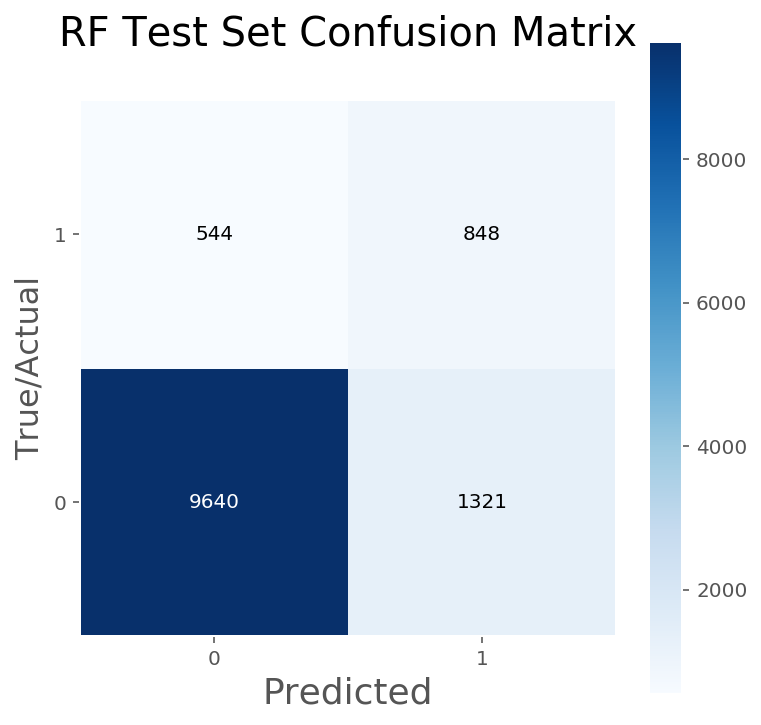

In [31]:
# Confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_rf, figsize=(6,6))
plt.title('RF Test Set Confusion Matrix', y=1.08, fontsize=20)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True/Actual', fontsize=16)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

#### The confusion matrix for the RF model above hows that it managed to predict 848 class "1" (successful subscriptions) out of a total of 544 + 848 = 1392 actual class "1" observations in the test set. That gives us a recall rate of 60.9%. Out of the model's predicted  2,169 class "1" observations, 848 of them were true class "1", which gives a precision rate of 39.1%. These precision and recall rates resulted in an F1 score on 47.6% on the class "1" category in the test set.

#### The optimised RF model also showed a smaller degradation in the F1 scores between the train and test sets (dropping from 0.57 to 0.48), compared to the simple RF model (dropping from 0.74 to 0.30), indicating that the former is more generalisable and robust.

### Logistic Regression (as a comparison)

In [32]:
# This was the top Logistic Regression model from the Gridsearches
logit = LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
logit.fit(X_train, y_train)

y_hat_train_lr = logit.predict(X_train)
y_hat_test_lr = logit.predict(X_test)

In [34]:
print("Test set accuracy score:", logit.score(X_test, y_test))
print("Test set F1 score:", f1_score(y_test, y_hat_test_lr, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_hat_test_lr))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_hat_test_lr, average='macro'))

Test set accuracy score: 0.7966485873876791
Test set F1 score: 0.41662796098467253
Test set Cohen's kappa: 0.31164329851287864
Test set ROC-AUC score: 0.7301902473975129


In [35]:
# Classification report on train set
print(classification_report(y_train, y_hat_train_lr))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     25576
           1       0.31      0.64      0.41      3247

    accuracy                           0.80     28823
   macro avg       0.63      0.73      0.65     28823
weighted avg       0.87      0.80      0.82     28823



In [36]:
# Classification report on test set
print(classification_report(y_test, y_hat_test_lr))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10961
           1       0.31      0.64      0.42      1392

    accuracy                           0.80     12353
   macro avg       0.63      0.73      0.65     12353
weighted avg       0.88      0.80      0.83     12353



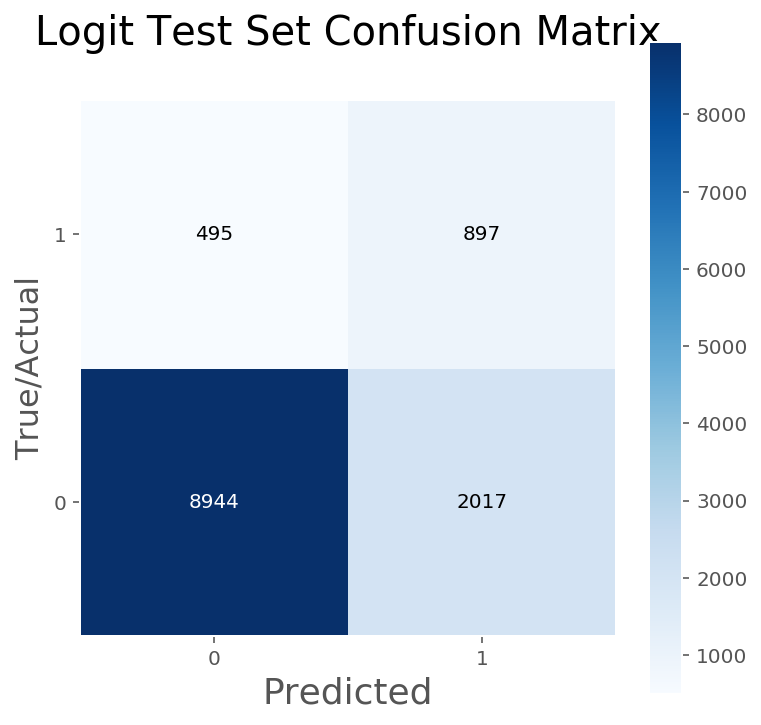

In [37]:
# Logit confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_lr, figsize=(6,6))
plt.title('Logit Test Set Confusion Matrix', y=1.08, fontsize=20)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True/Actual', fontsize=16)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

Compared to the Random Forest model above, the optimised logistic regression model performed much more poorly on the precision rate, though it had a slightly better recall rate. The logit model also produced uniformly weaker scores across the F1, Cohen's kappa and ROC-AUC measures, compared to the RF model.

# Random Forest's Variable "Importances"

### Feature Importances
Based on computing how much each feature contributed to decreasing the weighted impurity

In [38]:
feature_list = X_train.columns
feature_list

Index(['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar',
       'student', 'retiree', 'unemployed', 'single', 'no_default',
       'age_student', 'age_retiree', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed'],
      dtype='object')

In [39]:
f_importances = list(rf.feature_importances_)

In [40]:
df_features = pd.DataFrame(f_importances, index=X_train.columns, columns=['F-Importances'])

The feature importances measure however is known to be biased, and is not reliable in situations where potential predictor variables vary in their scale of measurement or their number of categories. So as a cross-check, I compute an alternative variable importances estimate below.

### Permutation Importances
Based on computing how random re-shuffling of each feature affects model performance as measured by a metric of choice

In [41]:
from rfpimp import permutation_importances

In [42]:
# Deriving the permutation importances with the F1 score metric
def var_impact(rf, X_train, y_train):
    return f1_score(y_train, rf.predict(X_train), average='binary')

p_importances = permutation_importances(rf, X_train, y_train, var_impact)

In [43]:
p_importances.columns = ['P-Importances']

In [44]:
# Merging both importances DFs on the common index of features
df_features = df_features.merge(p_importances, left_index=True, right_index=True)

### Comparison of variable "importances"

In [45]:
df_features.sort_values("P-Importances", ascending=False, inplace=True)
#df_features

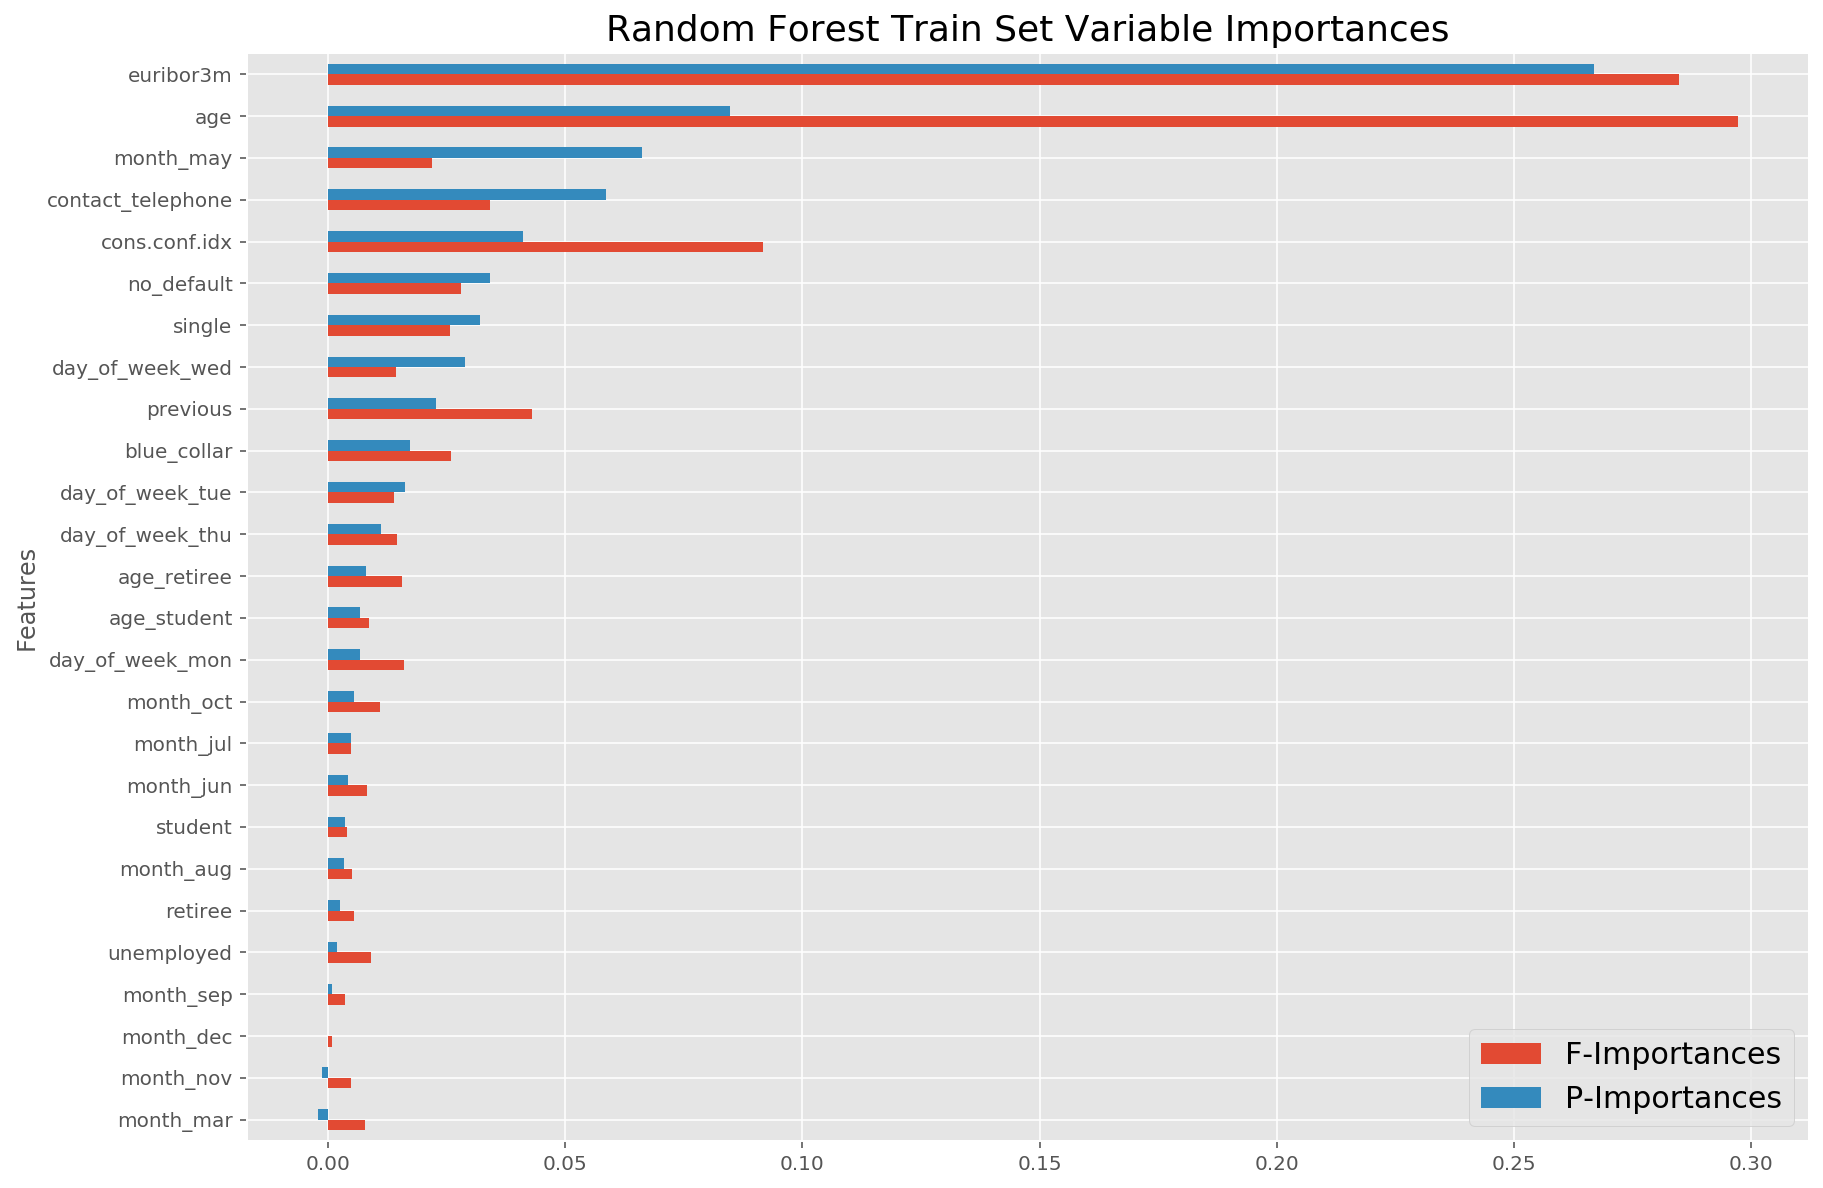

In [46]:
ax = df_features.sort_values(by='P-Importances').plot(kind='barh', figsize=(14,10))
ax.set_xlabel("")
ax.set_ylabel("Features")
ax.set_title("Random Forest Train Set Variable Importances", fontsize=18)
ax.legend(fontsize=15);

Both features importances and permutations importances agreed on most of their estimated top 10 variables. Nine variables were in both top 10 lists. 

#### The following four variables were in both top 5 lists: 'euribor3m', 'age', 'cons.conf.idx' and 'contact_telephone'.  The remaining top 10 variables were: 'month_may', 'previous', 'blue-collar', 'no_default' & 'single. 

All these 9 variables were also found to be statistically significant at the 95% confidence level in the Logistic regression model (summary table below). Incidentally, Logistic regression's top 5 coefficients' list also agreed on euribor3m and age too. The single largest coefficient from Logit was the 'age_retiree' interaction variable, but this was not found to be as important in Random Forest.

### Cross-check with logistic regression variable hypothesis tests

In [47]:
y_train_lr = pd.DataFrame(y_train)

In [48]:
y_train_lr.reset_index(drop=True, inplace=True)

In [49]:
logit_sm = sm.Logit(y_train_lr, X_train)
result = logit_sm.fit()

Optimization terminated successfully.
         Current function value: 0.291357
         Iterations 7


In [50]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28823
Model:                          Logit   Df Residuals:                    28797
Method:                           MLE   Df Model:                           25
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.1723
Time:                        13:37:45   Log-Likelihood:                -8397.8
converged:                       True   LL-Null:                       -10146.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
euribor3m            -2.3877      0.072    -33.350      0.000      -2.528      -2.247
cons.conf.idx         0.3862      0.118      3.270      0.001       0.155       0.618
age                  -1.3005      0.166     -7.848      0.000      -1.625      -0.976
previous              1.3024      0.185      7.023      0.000       0.939       1.666
blue_collar          -0.2844      0.057     -5.005      0.000      -0.396      -0.173
student              -0.0282      0.544     -0.052      0.959      -1.094       1.037
retiree              -1.0542      0.487     -2.165      0.030      -2.009      -0.100
unemployed           -0.0437      0.123     -0.354      0.723      -0.286       0.198
single               -0.1115      0.048     -2.334      0.020      -0.205      -0.018
no_default           -0.2011      0.051     -3.939      0.000      -0.301      -0.101
age_student           0.2519      0.951      0.265      0.791      -1.611       2.115
age_retiree           2.5417      0.729      3.486      0.000       1.113       3.971
contact_telephone    -0.1997      0.062     -3.212      0.001      -0.321      -0.078
month_aug            -0.1408      0.103     -1.369      0.171      -0.342       0.061
month_dec             0.4209      0.202      2.080      0.038       0.024       0.818
month_jul             0.2401      0.090      2.656      0.008       0.063       0.417
month_jun             0.1579      0.086      1.829      0.067      -0.011       0.327
month_mar             0.7407      0.121      6.142      0.000       0.504       0.977
month_may            -1.0798      0.066    -16.360      0.000      -1.209      -0.950
month_nov            -0.2203      0.096     -2.289      0.022      -0.409      -0.032
month_oct             0.2389      0.123      1.946      0.052      -0.002       0.479
month_sep             0.1182      0.131      0.902      0.367      -0.139       0.375
day_of_week_mon      -0.3577      0.062     -5.744      0.000      -0.480      -0.236
day_of_week_thu      -0.0881      0.059     -1.481      0.139      -0.205       0.028
day_of_week_tue      -0.0341      0.063     -0.543      0.587      -0.157       0.089
day_of_week_wed      -0.0386      0.063     -0.616      0.538      -0.162       0.084
=====================================================================================
"""

#### The top 10 logistic regression coefficients (all of which are statistically significant) are: age_retiree, euribor, previous, age, month_may, retiree, month_march, cons.conf.idx, month_dec, & blue_collar.

### The Random Forest "importances" measures and Logit all agree that the single most important explanatory variable in predicting a successful term deposit subscription is 'euribor3m'.

### Correlation matrix of the identified major variables

In [51]:
X_train.columns

Index(['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar',
       'student', 'retiree', 'unemployed', 'single', 'no_default',
       'age_student', 'age_retiree', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed'],
      dtype='object')

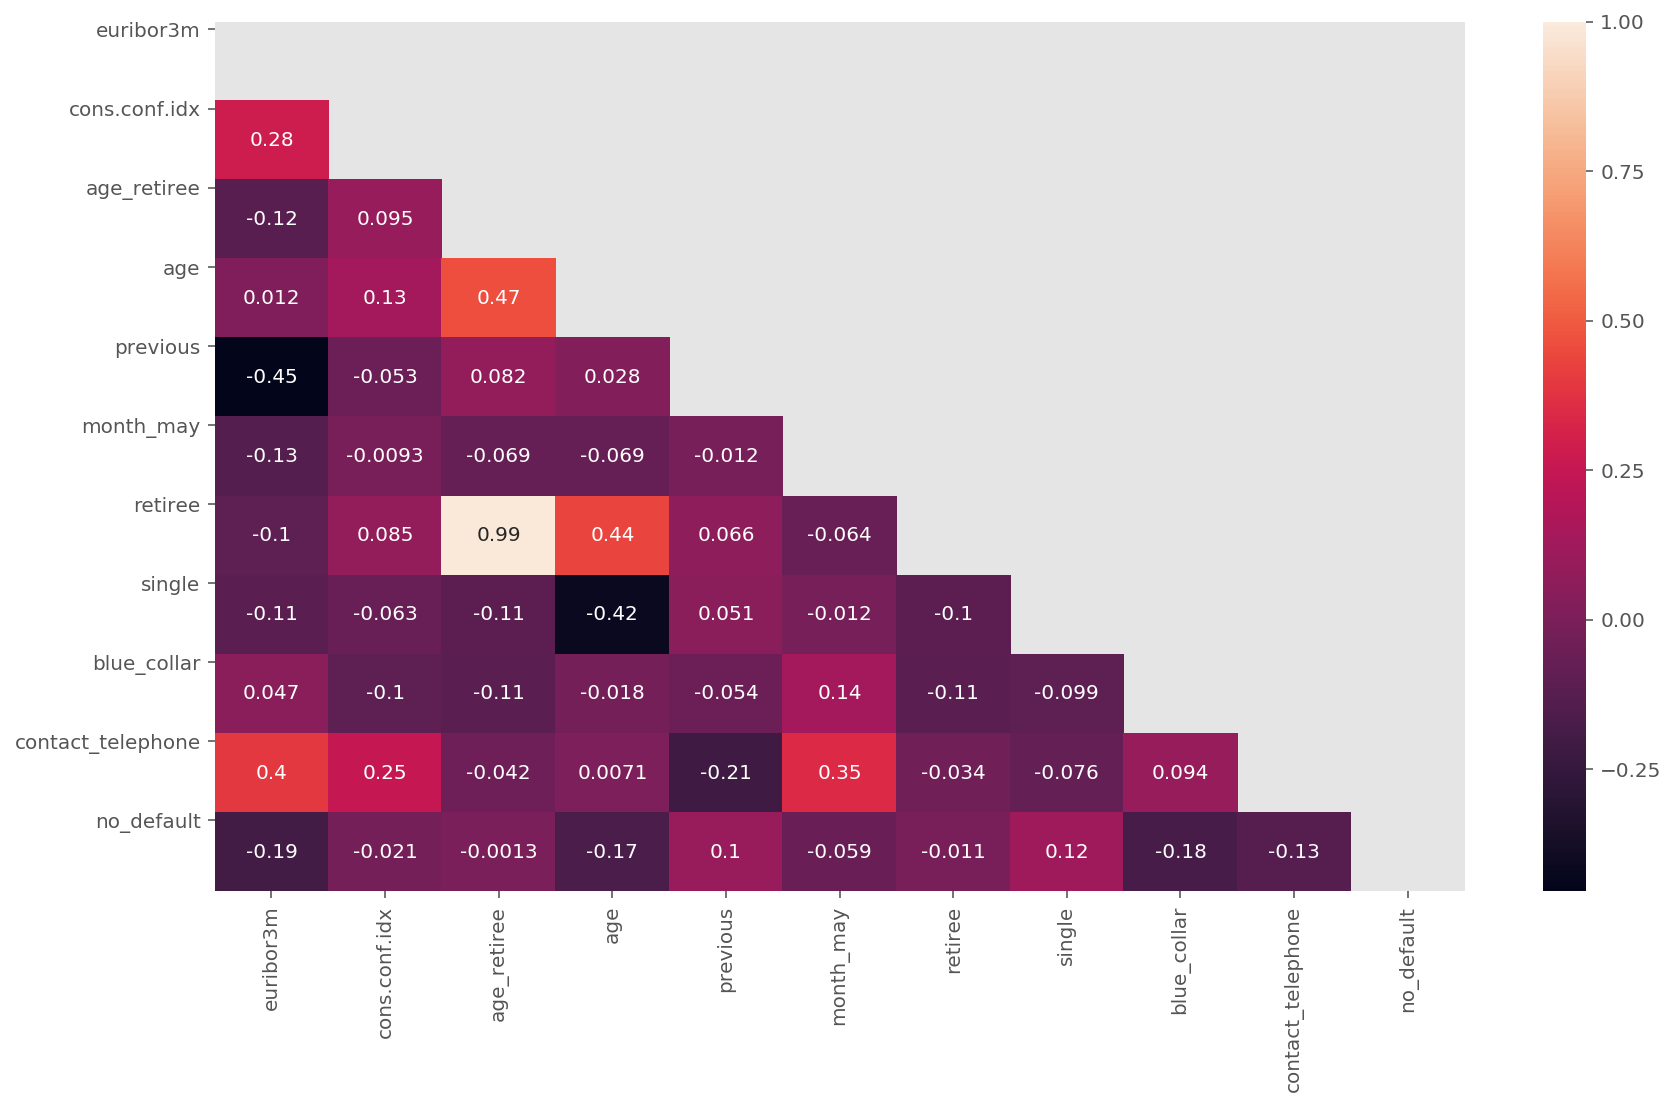

In [52]:
# Take a look at the correlation matrix for the new variables
W = X_train[['euribor3m', 'cons.conf.idx', 'age_retiree', 'age', 'previous', 'month_may', 'retiree', 'single', 'blue_collar', 
             'contact_telephone', 'no_default']]

fig, ax = plt.subplots(figsize=(14, 8))

mask = np.zeros_like(W.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(W.corr(), mask=mask, annot=True, ax=ax)
ax.set_yticks(np.arange(0, df.shape[1])+0.1)
ax.set_ylim([W.shape[1], 0])
plt.show()

Let's winnow down the nine variables: 'euribor3m', 'age', 'cons.conf.idx', 'contact_telephone', 'month_may', 'previous', 'blue-collar', 'no_default' & 'single. 

#### Given that 'euribor3m' and 'age' are the top two features according to both variable "importances" measures, I will use the two of them in the 5-variable model.

#### The first variable I would drop from the list is the 'month_may' dummy variable because it is not obvious to me why it helps explain the probability of a successful subscription to bank term deposits. The relationship may therefore be spurious, and not generalisable beyond this dataset. Moreover, using this dummy variable in a commercial-minded predictive model would imply that marketing should be conducted primarily in the single month of May. So I will drop 'month_may'.

#### 'retiree' and 'age_retiree' are highly correlated, and they are also well correlated with 'age'. There is also a moderate negative correlation between 'age' and 'single' at -0.42. So maybe we can drop 'single'.

#### 'contact_telephone' is also moderately correlated with 'euribor3m' at +0.40 for some reason. So perhaps we drop 'contact_telephone'.

#### 'previous' and 'euribor3m' are also well correlated at -0.45, but it makes sense the customers in more regular contact with the bank are more likely to subscribe to banking products. We saw in "Campaign_I" that 'previous' had moderate positive correlation to the target variable. The Logit model also found 'previous' to be among its top 3 variables. I would be inclined to keep 'previous'.

#### 'blue-collar' and 'no_default' by contrast are not well correlated with the other variables. In the logistic regression, the coefficient on 'no_default' was the weakest of these three variables. As we also saw in "Campaign_I", there were only 3 observations of no default in the variable and a lot of "unknown" observations, so the 'no_default' variable is possibly suspect. I would drop 'no_default' from the top 5 list.

#### 'cons.conf.idx' has some weak-to-moderate correlation with 'euribor3m', but 'cons.conf.idx' is in the top 5 list of both features and permutations importances. There is also an explainable link with bank term deposit subscriptions in that in times of economic stress, which would cause consumer confidence to fall, people are more likely to take up relatively low risk investments. 

#### So let's use 'euribor3m', 'cons.conf.idx', 'age', 'previous' and 'blue_collar' in the 5-variable model Gridsearch. Apart from Random Forest, I will also perform the Gridsearch on Logistic Regression, given that the latter is the workshorse of classification models and useful for statistical inference and hypothesis testing. Both RF and Logit would be able to output the predicted probabilities, so both are "soft classification" models.

### The analysis is continued in the "Campaign_III" file